# Using Variational Autoencoder to create new imagems

## Background

We have two examples of puppies from which we want to identify the probable cracks that led to their creation. To do this, we will train a model with interpolation capabilities between the encoder and the decoder.

The project was made possible according to the [proposed planning](../docs/planning.md)

## Measure of Success

Validation will be done through visualization by identifying similarities between the breeds.

# 0.0 Imports

In [1]:
from zipfile import ZipFile
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from PIL import Image

import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torch.autograd import Variable
from scipy.spatial import distance

import sys
sys.path.append("../src/")
from models.vae import VAE

## 0.1 Load Data

In [13]:
zip_path = '../data/01_raw/train.zip'
extract_to = '../data/01_raw/'

with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

## 0.2 Helper Functions

In [2]:
def unnormalize(image):
    image = image.to('cpu').clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

# 1.0 Prepare Data

- I'm going to upload the image labels for better identification, and this time I'm going to apply several transformations.

In [17]:
df = pd.read_csv('../data/01_raw/labels.csv')
synset = sorted(set(df['breed']))
n = len(df)

transform1 = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64)
])
random_transforms = [transforms.RandomRotation(degrees=10)]
transform2 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply(random_transforms, p=0.3),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.ToTensor(),
])

X = torch.zeros((n, 3, 64, 64), dtype=torch.float)
y = torch.zeros((n,), dtype=torch.long)

for i, (fname, breed) in tqdm(df.iterrows(), total=n):
    img_path = f'../data/01_raw/{fname}.jpg'
    img = Image.open(img_path).convert('RGB')
    img = transform1(img)
    img = transform2(img)
    X[i] = img
    y[i] = synset.index(breed)

dataset = TensorDataset(X, y)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

100%|██████████| 10222/10222 [00:24<00:00, 419.54it/s]


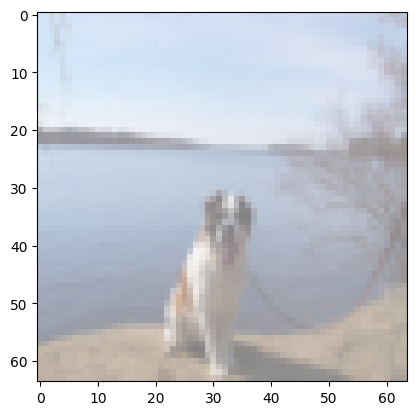

In [4]:
sample_images, _ = next(iter(data_loader))

plt.imshow((sample_images[0].numpy().transpose(1, 2, 0)+1)/2)
plt.show()

# 2.0 Variational Autoencoder

- I'm going to use a model built by this [repository](https://github.com/atinghosh/VAE-pytorch)

In [7]:
lr = 0.001
epochs = 8
latent_dim = 32
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE(latent_dim, batch_size=batch_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

## 2.1 Machine Learning

In [ ]:
for epoch in range(1, epochs+1):
    model.train()
    print(f'Epoch {epoch} start')
    
    for data in data_loader:
        imgs, _ = data
        imgs = imgs.to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(imgs)
        loss = model.loss_function(recon_batch, imgs, mu, logvar)

        loss.backward()
        optimizer.step()
        
    model.eval()
    recon_img, _, _ = model(sample_images[:1].to(device))
    img = recon_img.view(3, 64, 64).detach().cpu().numpy().transpose(1, 2, 0)
    
    plt.imshow((img+1.)/2.)
    plt.show()

In [5]:
model_path = '../data/06_models/v2model_vae.pth'
torch.save(model.state_dict(), model_path)

In [ ]:
model = VAE(latent_dim=latent_dim, batch_size=batch_size)

model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

model.to(device)

model.eval()

# 3.0 Explore and test Model

- Now I'm going to show you some samples to demonstrate the model's capabilities.

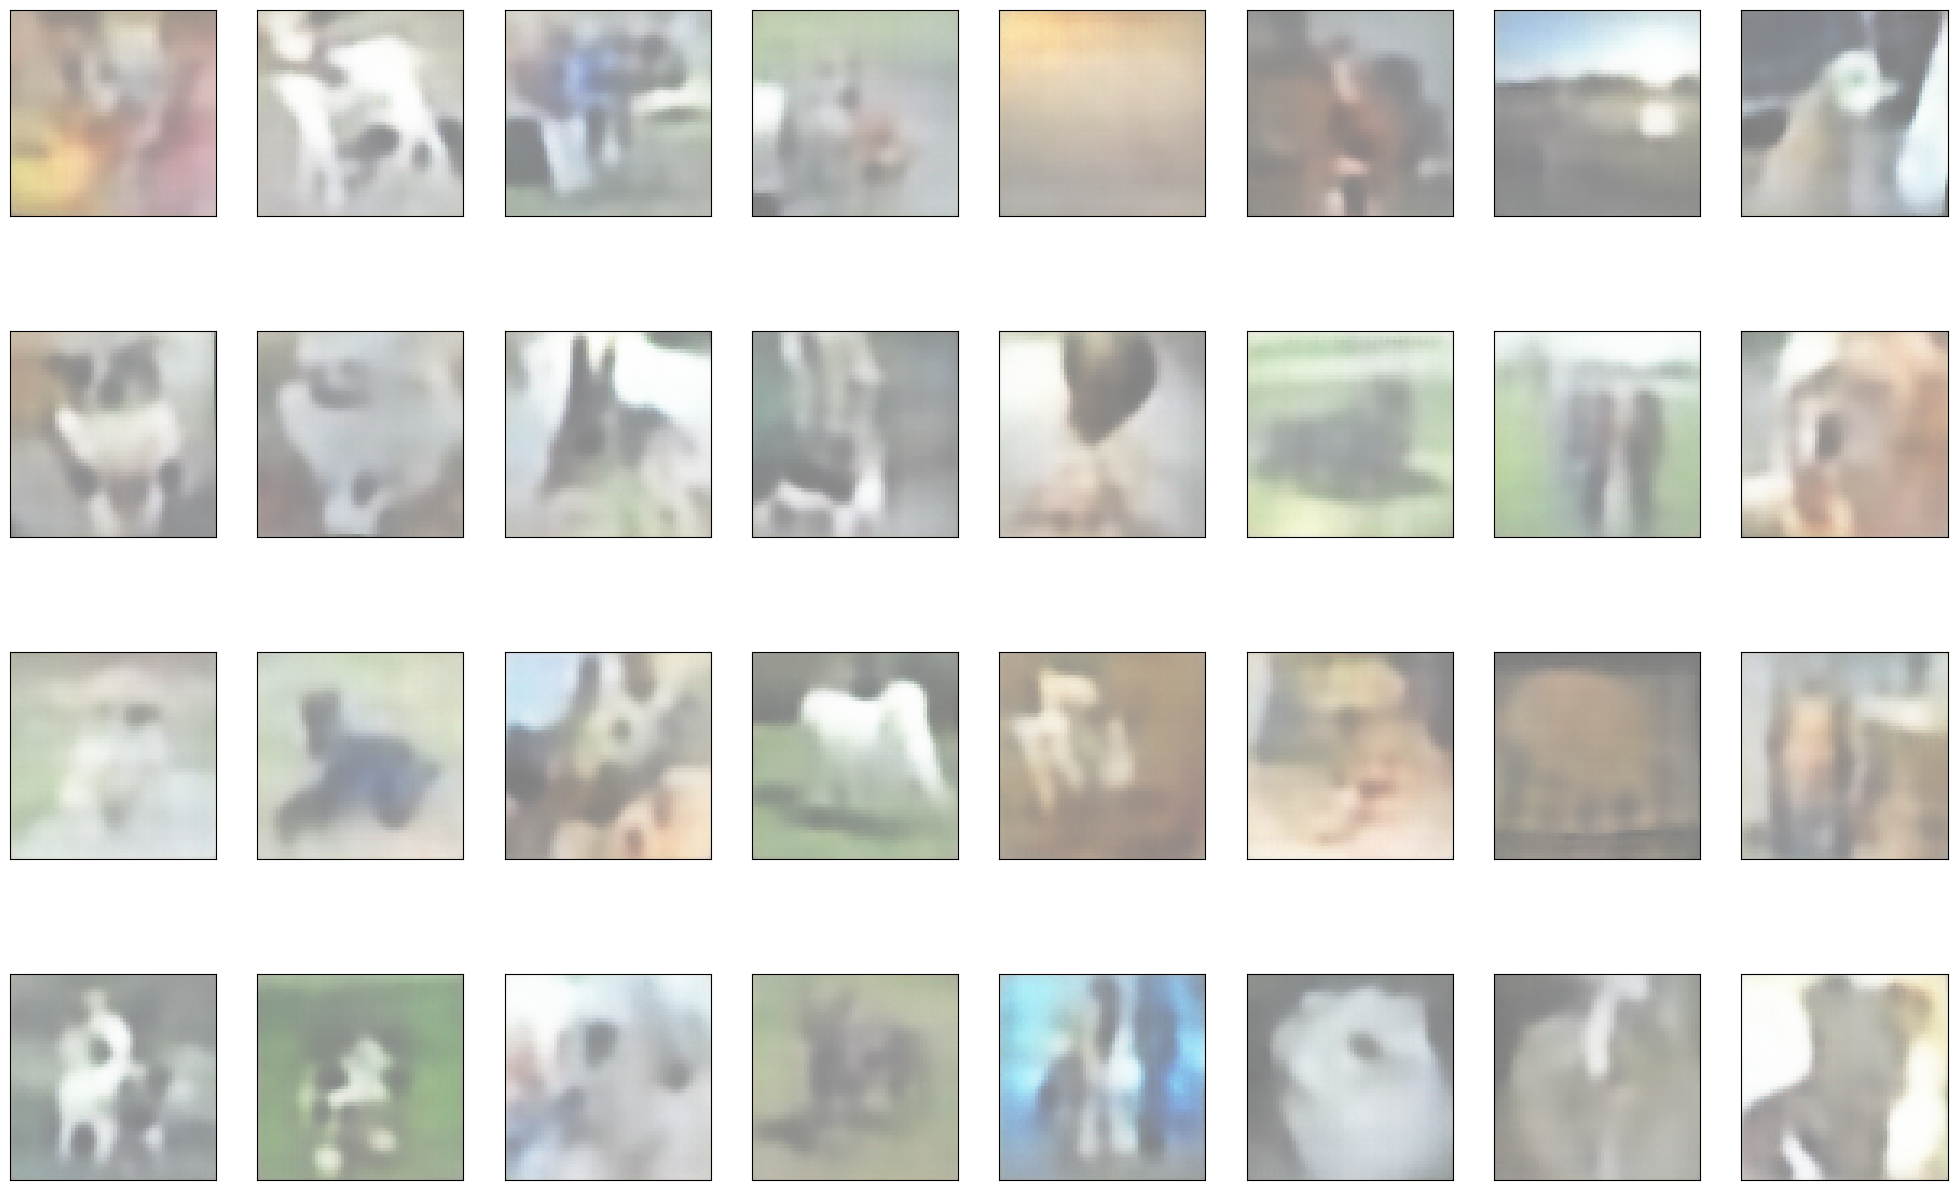

In [9]:
sample_images, _ = next(iter(data_loader))
sample_images = sample_images.to(device)

with torch.no_grad():
    reconstructed, _, _ = model(sample_images)

reconstructed = reconstructed.view(-1, 3, 64, 64)
reconstructed = reconstructed.detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(reconstructed):
    if ii >= 32:
        break
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img * 0.5) + 0.5)

- Finally, I will analyze how two images are interpolated with this model.

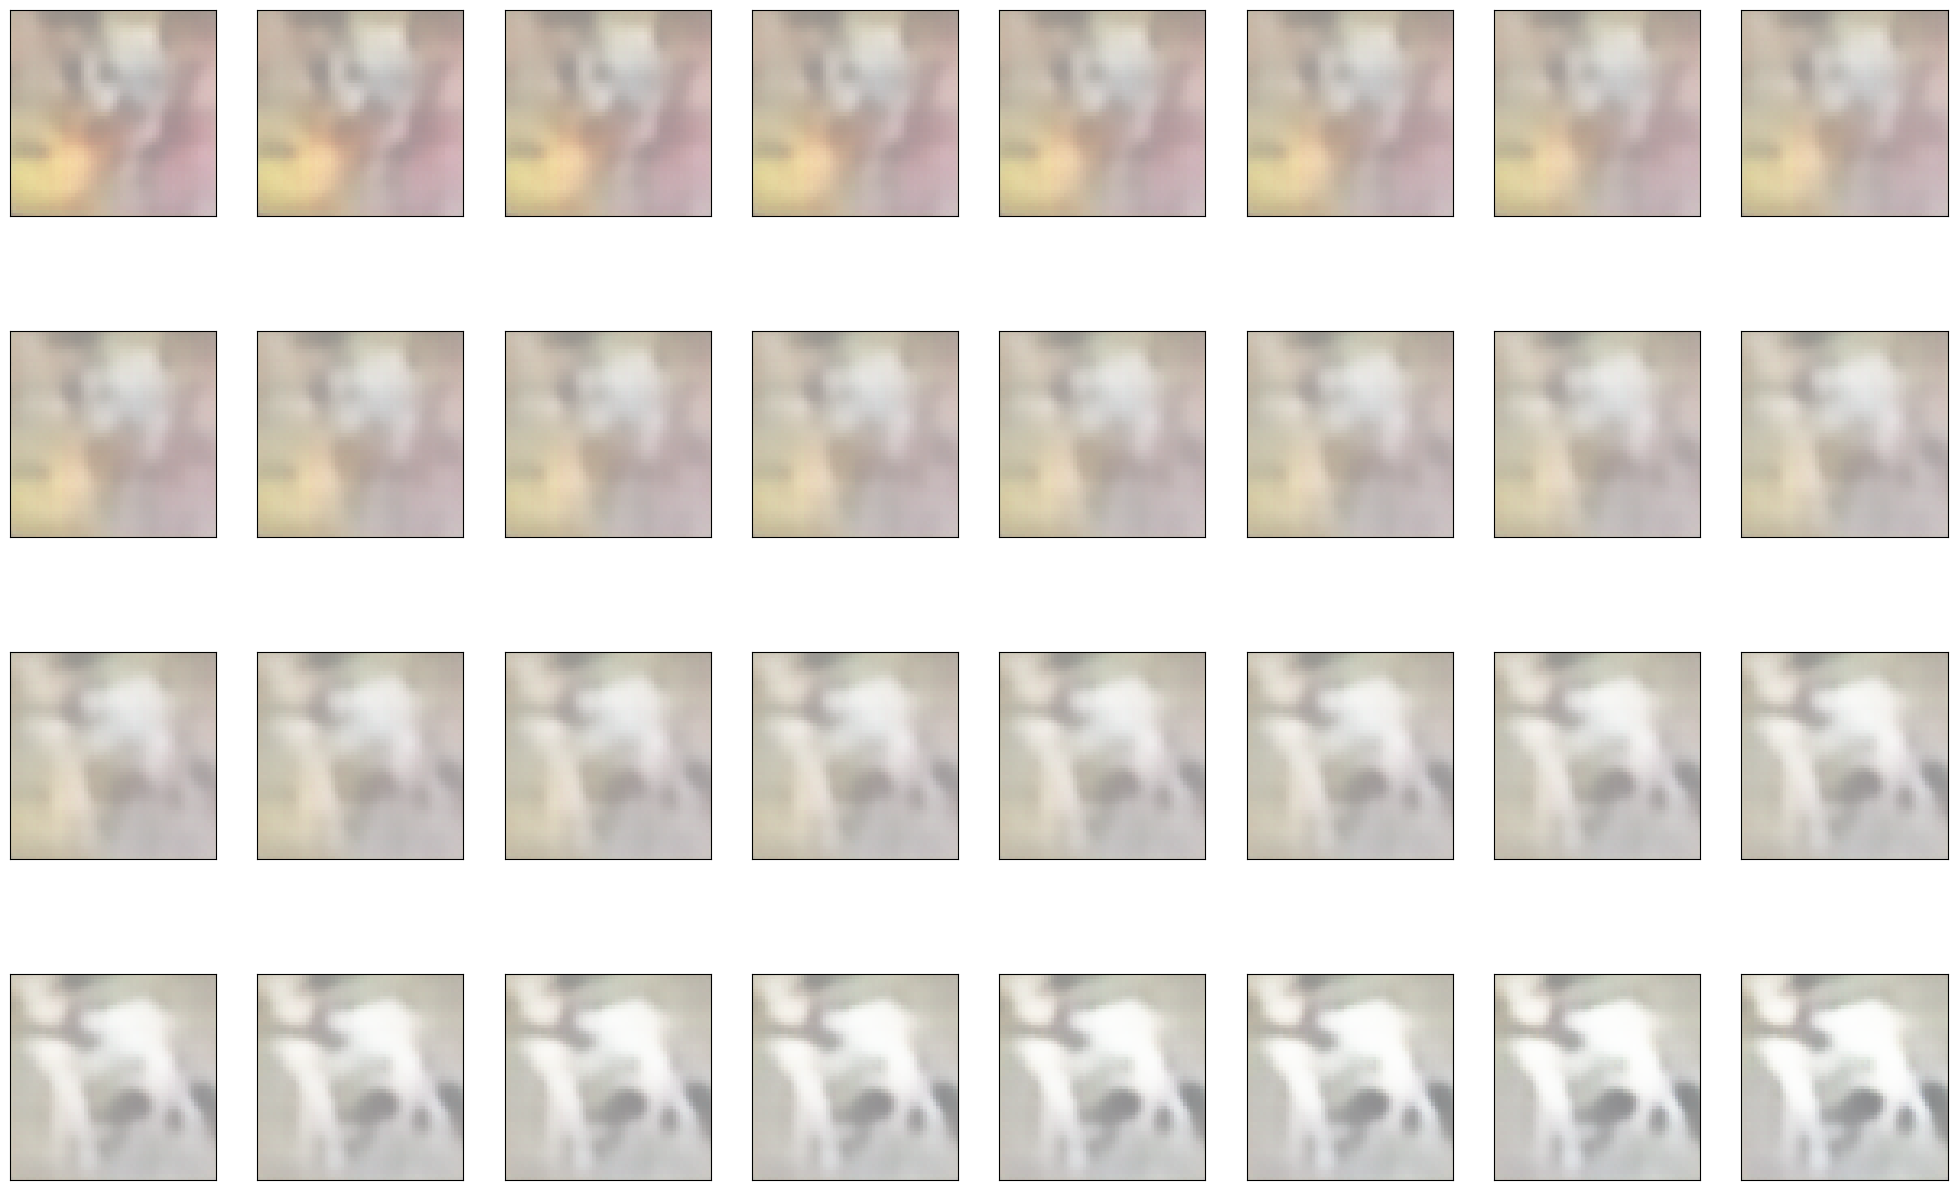

In [10]:
with torch.no_grad():
    mu, _ = model.encode(sample_images)

first_dog_idx = 0
second_dog_idx = 1

dz = (mu[second_dog_idx] - mu[first_dog_idx]) / 31
walk = Variable(torch.randn(32, latent_dim, 4, 4)).to(device)
walk[0] = mu[first_dog_idx]

for i in range(1, 32):
    walk[i] = walk[i-1] + dz
walk = model.decoder(walk).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(walk):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img+1.)/2.)

# 4.0 Identifies similarities

- First let's load the two validation images, we want to understand which breeds have the greatest similarities.

In [18]:
model.eval()

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

image_paths = ['../data/05_model_input/pythinho.png', '../data/05_model_input/caramelo.png']

images = []
for image_path in image_paths:
    image = Image.open(image_path).convert('RGB')
    image = transform1(image)
    image = transform2(image).unsqueeze(0)
    images.append(image.to(device))

images_tensor = torch.cat(images, dim=0)

with torch.no_grad():
    mu, _ = model.encode(images_tensor)

In [19]:
mus_train = []
labels_train = []

model.eval()
with torch.no_grad():
    for imgs, labels in data_loader:
        imgs = imgs.to(device)
        mu, _ = model.encode(imgs)
        mus_train.append(mu.view(imgs.size(0), -1))
        labels_train.append(labels)

mus_train = torch.cat(mus_train, dim=0)
labels_train = torch.cat(labels_train, dim=0)

- I will compare the smallest distances in latent space between the new images and the training images, so that I can measure the most similar images.

In [20]:
with torch.no_grad():
    mu_new_images, _ = model.encode(images_tensor)
    mu_new_images_flattened = mu_new_images.view(mu_new_images.size(0), -1).cpu().numpy()

mus_train_flattened = mus_train.view(mus_train.size(0), -1).cpu().numpy()

n_closest = 5

closest_breeds_per_image = []

for mu_single in mu_new_images:
    mu_single_flattened = mu_single.view(1, -1).cpu().numpy()
    distances = distance.cdist(mu_single_flattened, mus_train_flattened, 'euclidean')

    closest_idxs = np.argsort(distances[0])[:n_closest]

    closest_breeds = [synset[labels_train[idx].item()] for idx in closest_idxs]
    closest_breeds_per_image.append(closest_breeds)

for i, breeds in enumerate(closest_breeds_per_image):
    print(f"Image {i+1} closest breeds: {breeds}")

Image 1 closest breeds: ['newfoundland', 'irish_setter', 'bernese_mountain_dog', 'maltese_dog', 'groenendael']
Image 2 closest breeds: ['pembroke', 'weimaraner', 'brabancon_griffon', 'african_hunting_dog', 'irish_terrier']


- Here we can identify which breeds are most similar to the pythinho and caramel puppy.

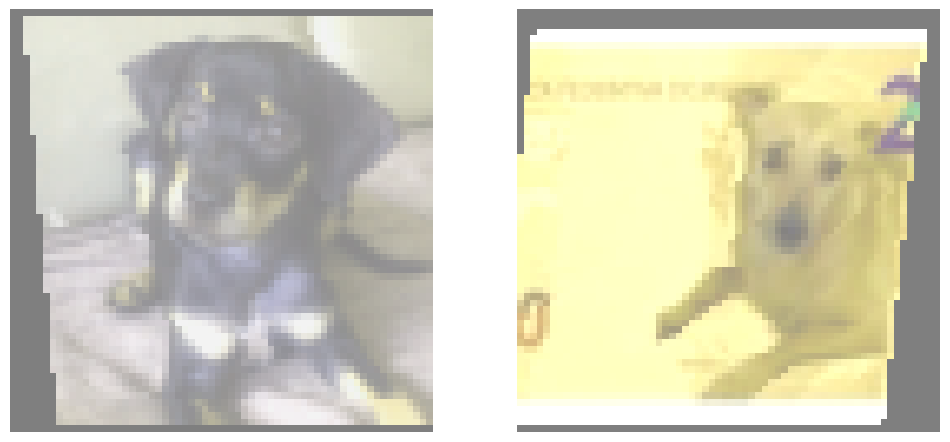

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i, image in enumerate(images_tensor):
    img = unnormalize(image)
    axs[i].imshow(img)
    axs[i].axis('off')

plt.show()

- Finally, we're going to interpolate several of the similar breeds with both dogs to infer which has the greatest similarity and thus identify which combined breeds give rise to both.

Interpolation between the new image 1 and the race newfoundland.


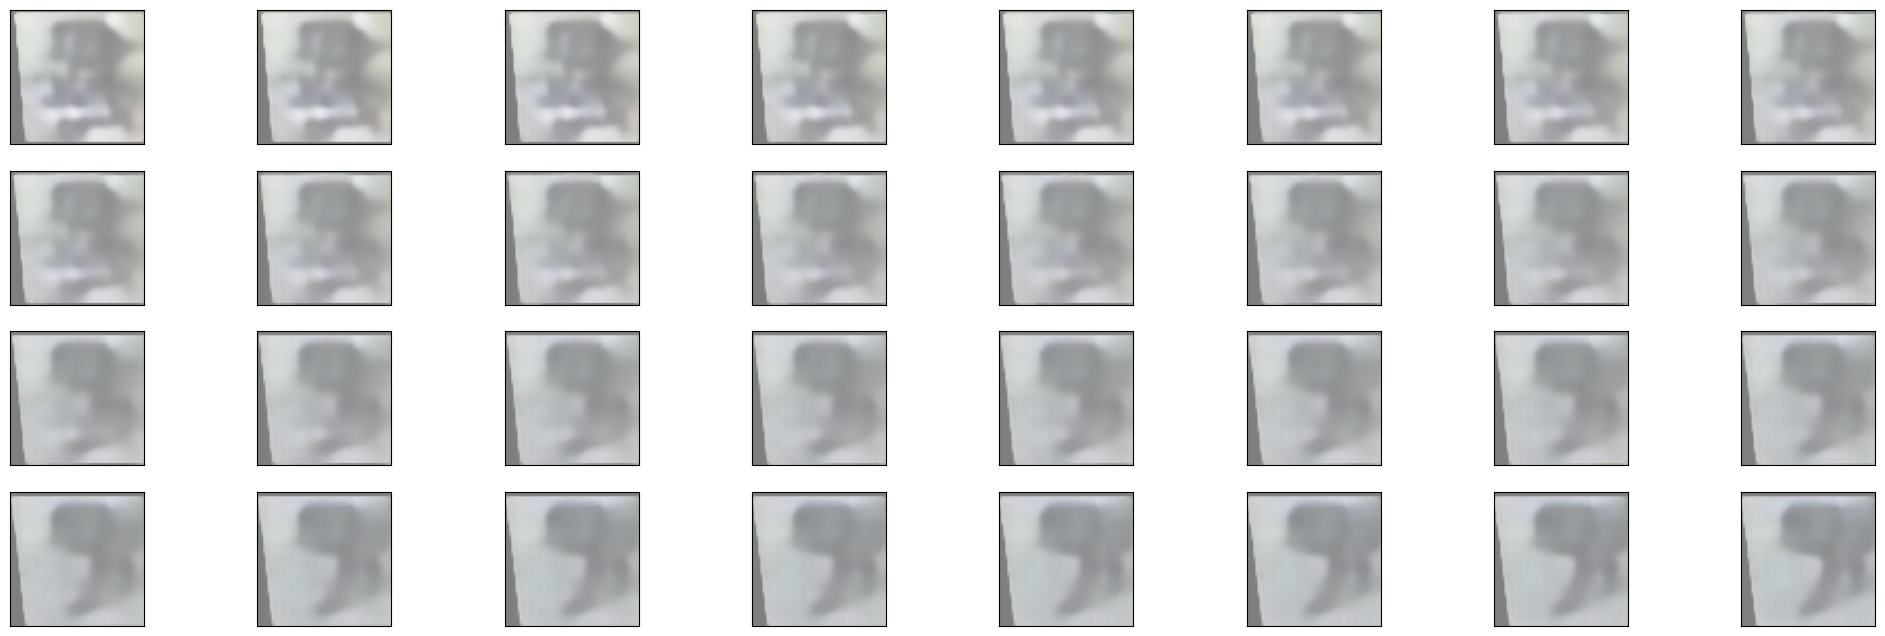

Interpolation between the new image 1 and the race irish_setter.


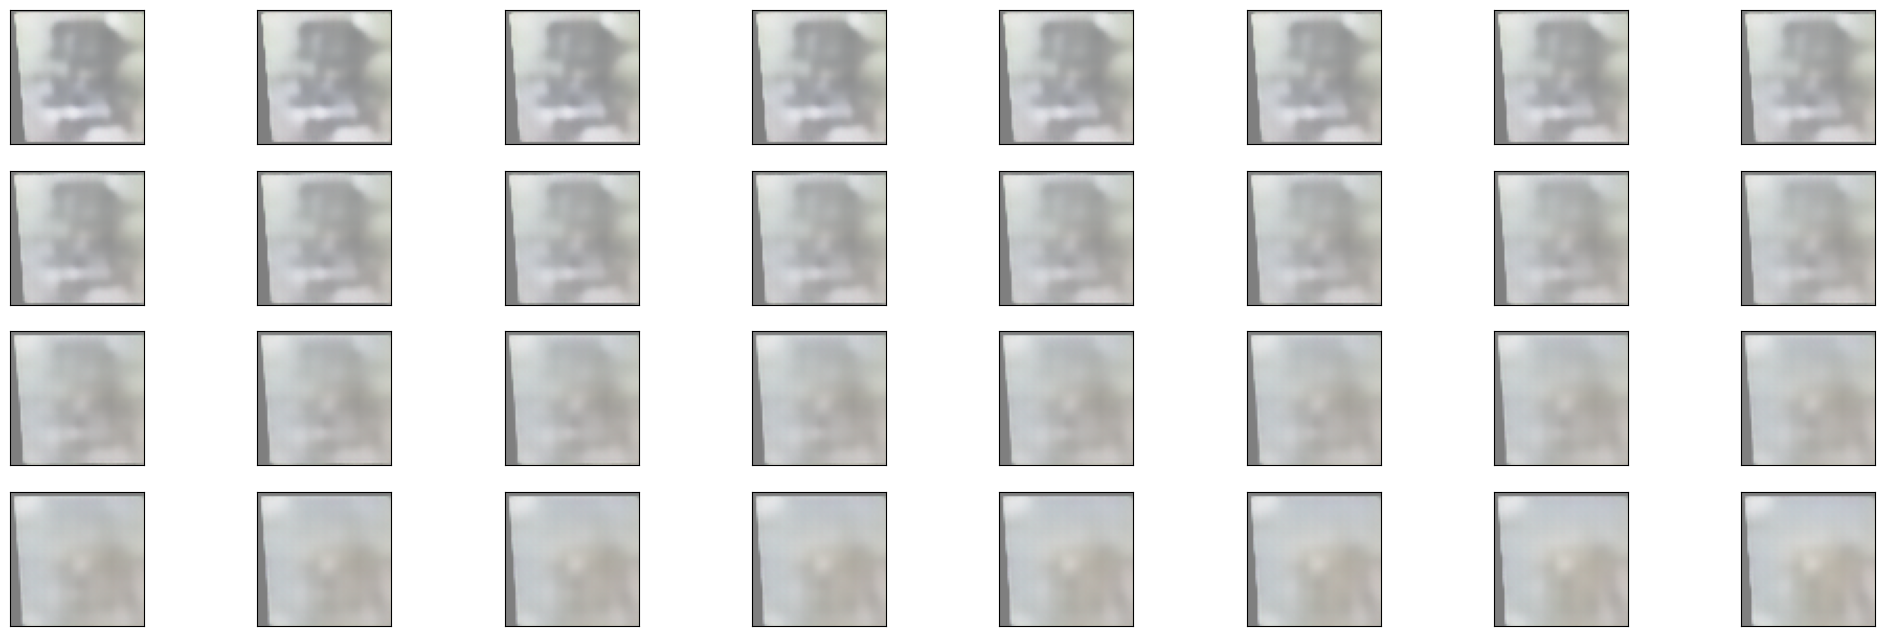

Interpolation between the new image 1 and the race bernese_mountain_dog.


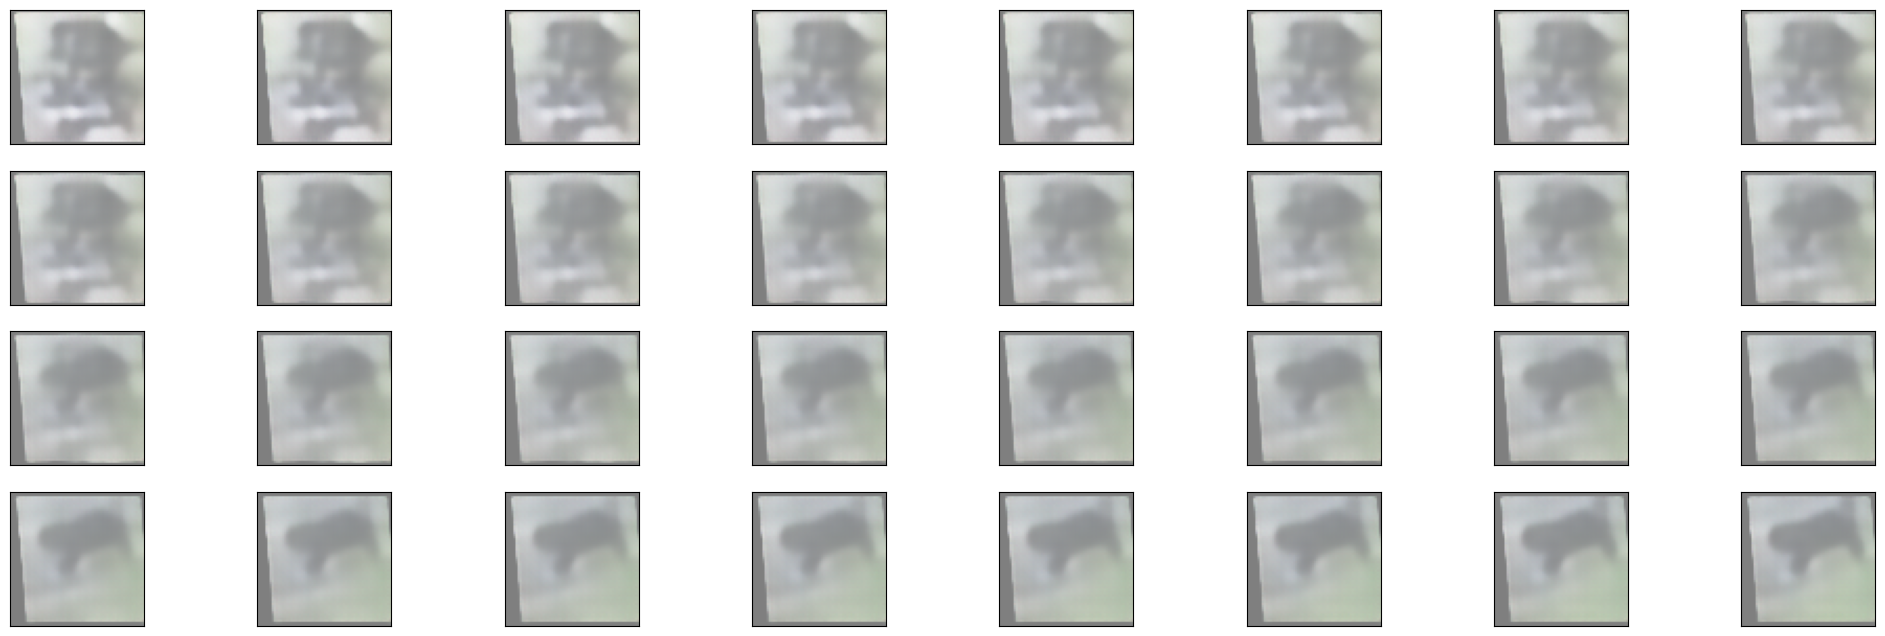

Interpolation between the new image 2 and the race pembroke.


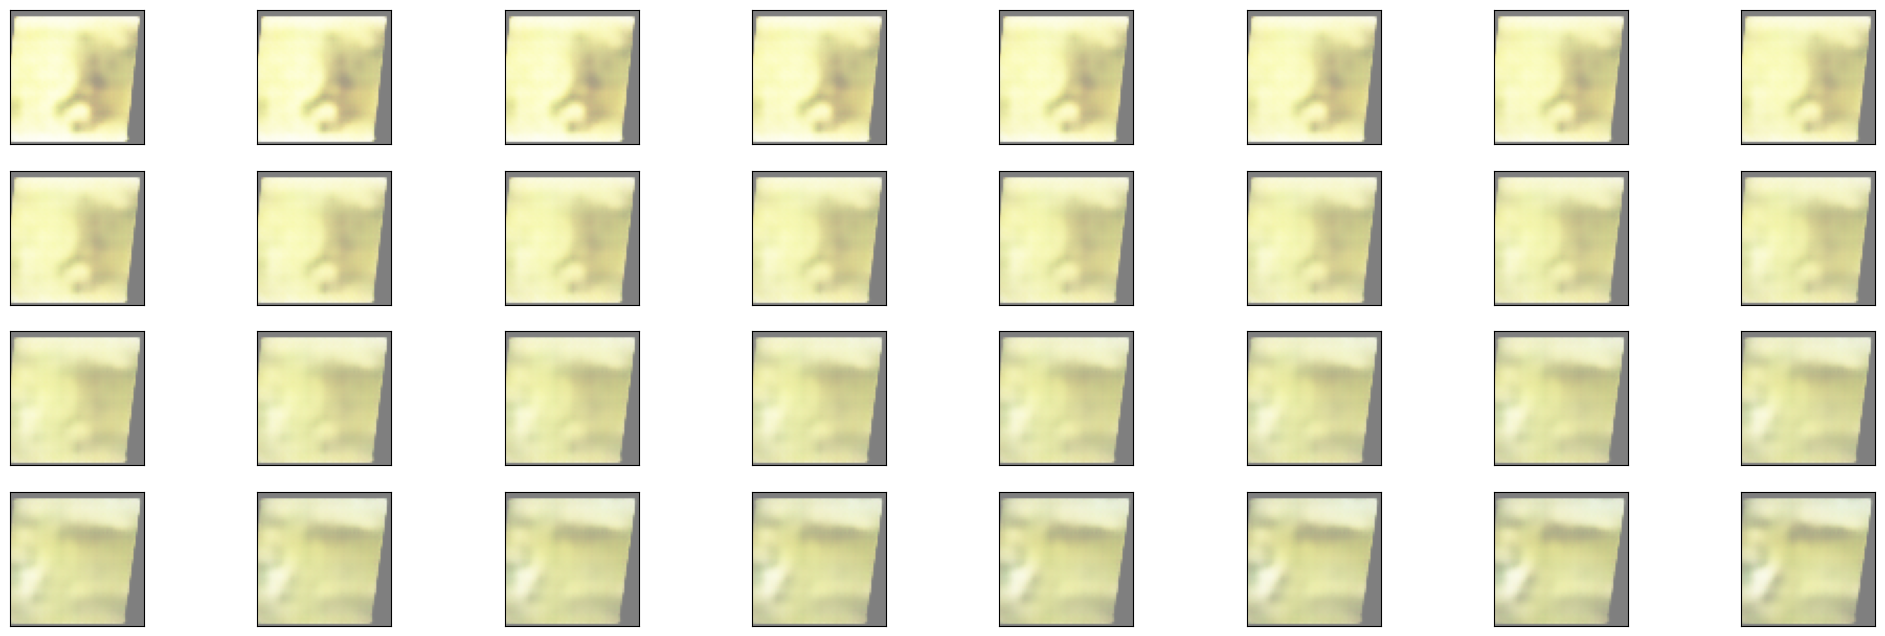

Interpolation between the new image 2 and the race weimaraner.


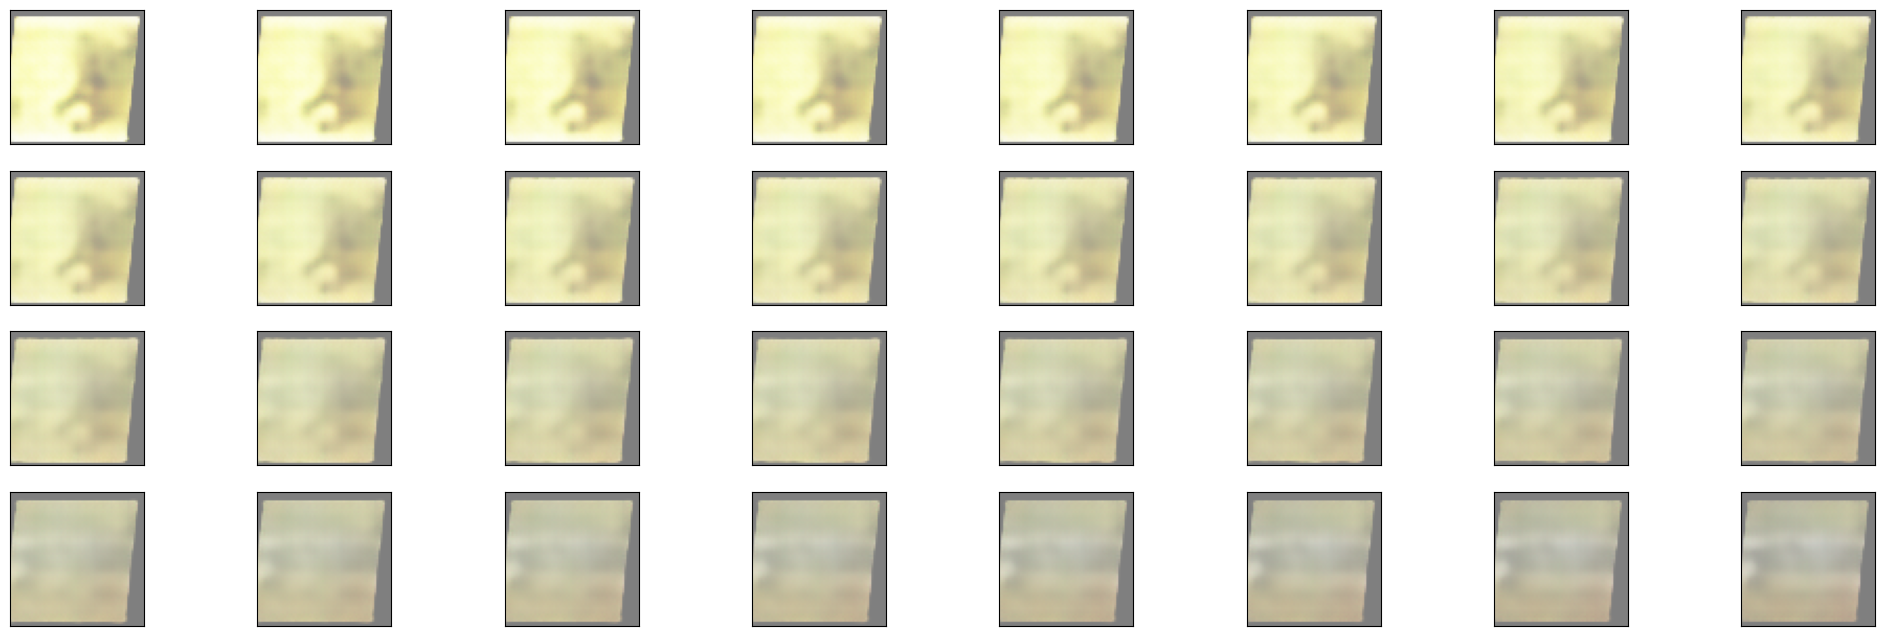

Interpolation between the new image 2 and the race brabancon_griffon.


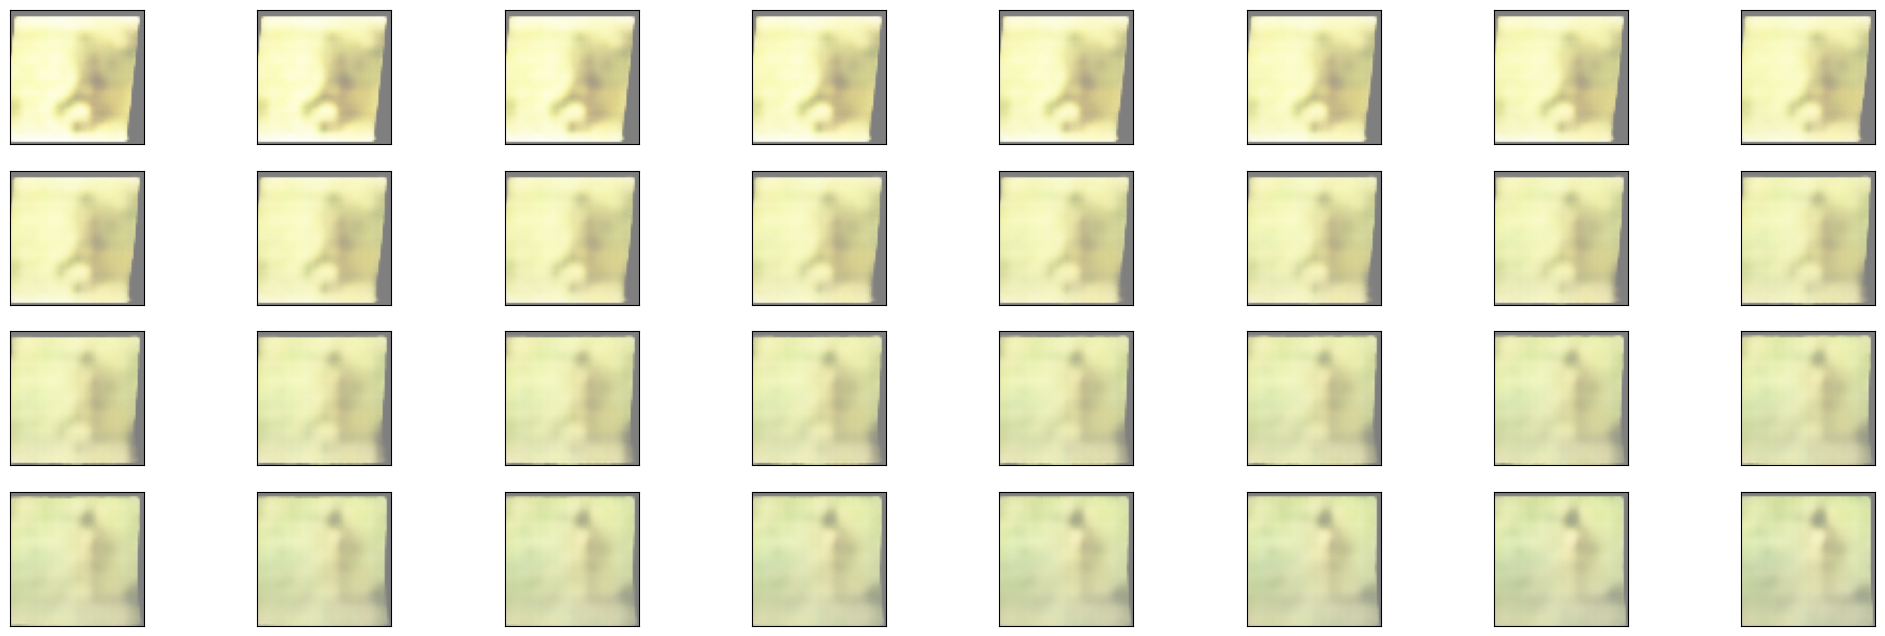

In [23]:
for i, mu_new_image in enumerate(mu_new_images):
    closest_idxs = np.argsort(distance.cdist(mu_new_image.view(1, -1).cpu().numpy(), mus_train_flattened, 'euclidean')[0])[:3]
    
    for j, idx in enumerate(closest_idxs):
        mu_closest_breed = mus_train[idx].view(mu_new_image.shape).to(device)

        dz = (mu_closest_breed - mu_new_image) / 31
        walk = torch.zeros((32, *mu_new_image.shape), device=device)
        walk[0] = mu_new_image
        
        for k in range(1, 32):
            walk[k] = walk[k-1] + dz

        interpolated_images = model.decoder(walk).detach().cpu().numpy().transpose(0, 2, 3, 1)
        
        breed_name = synset[labels_train[idx].item()]
        print(f"Interpolation between the new image {i+1} and the race {breed_name}.")
        
        fig = plt.figure(figsize=(25, 8))
        for ii, img in enumerate(interpolated_images):
            ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
            plt.imshow((img + 1) / 2)
        plt.show()

- Here we were able to successfully use interpolation to compare the images in their similarities using the VAE.